In [1]:
import torch
device = 'cpu'
import matplotlib.pyplot as plt
import numpy as np
from models.training import create_dataloader


# Juptyer magic: For export. Makes the plots size right for the screen 
%matplotlib inline
# %config InlineBackend.figure_format = 'retina'

%config InlineBackend.figure_formats = ['svg'] 

torch.backends.cudnn.deterministic = True
seed = np.random.randint(1,200)
seed = 56
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
print(seed)
g = torch.Generator()
g.manual_seed(seed)

# design choices 
chosen_problem = 'restricted_TS'
data_noise = 0.
n_different_weights = 1
if n_different_weights == 1:
    print('This choice will generate autonomous dynamics')
else:
    print('This choice generates non-autonomous dynamics, letting the weights depend on time')

possible_problem = {'moons':'moons', 'ToggleSwitch':'TS', 'repressilator':'repr', 'restricted_TS': 'restrictedTS'} 
# this choices determine the data set that we build and subsequent choices on the construction of the neural ODE 
# - in particular, it determines the dimensions 
problem = possible_problem[chosen_problem]

plotlim = [0, 5]

56
This choice will generate autonomous dynamics


In [2]:
ind = 0
m1vec = []
m2vec = []
lossvec = []
var1vec = []
var2vec = []
for sz in range(2,11):

    m1vectemp = []
    m2vectemp = []
    lossvectemp = []

    for k in range(0,20):
        
        ind = ind + 1
        seed = ind

        dataloader, dataloader_viz = create_dataloader(problem, batch_size = sz, noise = data_noise, 
                                                    plotlim = plotlim, random_state = seed, label = 'vector')

        #Import of the model dynamics that describe the neural ODE
        #The dynamics are based on the torchdiffeq package, that implements ODE solvers in the pytorch setting
        from models.neural_odes import NeuralODE

        #T is the end time of the neural ODE evolution, num_steps are the amount of discretization steps for the ODE solver
        T, num_steps = 1, n_different_weights
        bound = 0.
        fp = False
        cross_entropy = False
        turnpike = False

        # choice of model: what nonlinearity is used and if the nonlinearity is applied before (inside) or after (outside) the linear weights
        # another choice is bottleneck, but I don't understand it
        # non_linearity = 'tanh' # OR 'relu' 'sigmoid' 'leakyrelu' 'tanh_prime'
        # architecture = 'inside' 'outside'
        non_linearity = 'tanh'
        architecture = 'restricted'
        architectures = {'inside': -1, 'outside': 0, 'bottleneck': 1, 'restricted': 2}
        # number of optimization runs in which the dataset is used for gradient decent
        num_epochs = 50
        if problem == 'moons' or problem == 'TS' or problem == "restrictedTS":
            hidden_dim, data_dim = 2, 2 
        else:
            hidden_dim, data_dim = 3, 3 
        augment_dim = 0

        # resets the seed - allows for coherent runs in the gradient descent as well
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        anode = NeuralODE(device, data_dim, hidden_dim, output_dim=data_dim, augment_dim=augment_dim, non_linearity=non_linearity, 
                            architecture=architecture, T=T, time_steps=num_steps, fixed_projector=fp, cross_entropy=cross_entropy)
        optimizer_anode = torch.optim.Adam(anode.parameters(), lr=1e-1)

        from models.training import doublebackTrainer

        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        trainer_anode = doublebackTrainer(anode, optimizer_anode, device, cross_entropy=cross_entropy, turnpike = turnpike,
                                bound=bound, fixed_projector=fp, verbose = True, eps_comp = 0.2)

        trainer_anode.train(dataloader, 100)

        W1 = anode.flow.dynamics.fc1_time[0].weight
        W1 = W1.detach().numpy()
        m1 = abs(W1[0][1]-W1[1][0])
        m2 = abs(W1[0][0])+abs(W1[1][1])

        lv = trainer_anode.histories["loss_history"]
        l = lv[-1]

        m1vectemp.append(m1)
        m2vectemp.append(m2)
        lossvectemp.append(l)
    
    m1vec.append(np.mean(m1vectemp))
    m2vec.append(np.mean(m2vectemp))
    lossvec.append(np.mean(lossvectemp))
    var1vec.append(np.var(m1vectemp))
    var2vec.append(np.var(m2vectemp))

No change  applied to TS or repr data
Epoch 1: 12.375
Epoch 2: 10.575
Epoch 3: 7.035
Epoch 4: 3.640
Epoch 5: 1.563
Epoch 6: 0.512
Epoch 7: 0.315
Epoch 8: 0.597
Epoch 9: 0.929
Epoch 10: 1.132
Epoch 11: 1.185
Epoch 12: 1.111
Epoch 13: 0.942
Epoch 14: 0.711
Epoch 15: 0.465
Epoch 16: 0.251
Epoch 17: 0.103
Epoch 18: 0.032
Epoch 19: 0.059
Epoch 20: 0.083
Epoch 21: 0.120
Epoch 22: 0.140
Epoch 23: 0.152
Epoch 24: 0.144
Epoch 25: 0.131
Epoch 26: 0.120
Epoch 27: 0.112
Epoch 28: 0.113
Epoch 29: 0.125
Epoch 30: 0.140
Epoch 31: 0.146
Epoch 32: 0.139
Epoch 33: 0.127
Epoch 34: 0.120
Epoch 35: 0.122
Epoch 36: 0.128
Epoch 37: 0.136
Epoch 38: 0.138
Epoch 39: 0.136
Epoch 40: 0.129
Epoch 41: 0.124
Epoch 42: 0.121
Epoch 43: 0.125
Epoch 44: 0.129
Epoch 45: 0.129
Epoch 46: 0.126
Epoch 47: 0.122
Epoch 48: 0.122
Epoch 49: 0.123
Epoch 50: 0.125
Epoch 51: 0.125
Epoch 52: 0.124
Epoch 53: 0.122
Epoch 54: 0.120
Epoch 55: 0.120
Epoch 56: 0.122
Epoch 57: 0.122
Epoch 58: 0.121
Epoch 59: 0.119
Epoch 60: 0.118
Epoch 61:

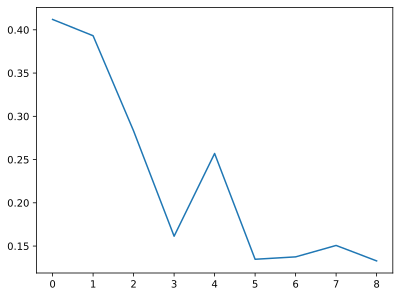

In [6]:
plt.plot(m1vec)

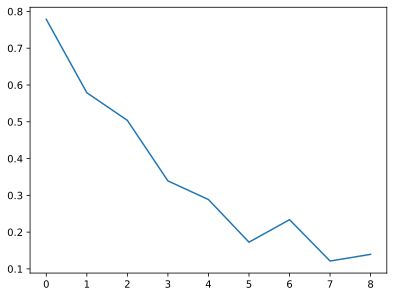

In [7]:
plt.plot(m2vec)

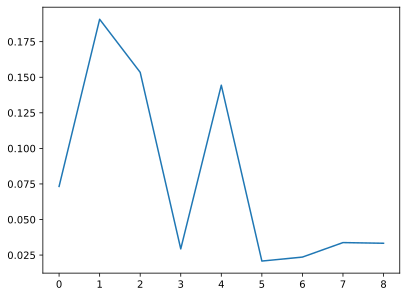

In [8]:
plt.plot(var1vec)

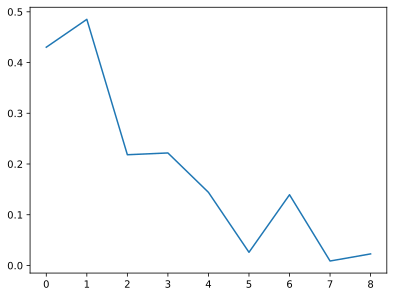

In [9]:
plt.plot(var2vec)